In [326]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import os
from keras import initializers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


import quandl
quandl.read_key()

In [470]:
col_list = ['MULTPL/SP500_REAL_PRICE_MONTH',
            'MULTPL/SP500_DIV_YIELD_MONTH',
            'MULTPL/SP500_PE_RATIO_MONTH',
            'FRED/M2SL', 
            'FRED/T10Y2Y',
            'FRED/PAYEMS',
            'FRED/CPIAUCSL',
            'FRED/INDPRO']

col_list = ['MULTPL/SP500_REAL_PRICE_MONTH',
            'MULTPL/SP500_PE_RATIO_MONTH',
            'FRED/PAYEMS',
            'FRED/GS1',
            'FRED/IPMANSICS',
            'FRED/CPIAUCSL']

name_dict = {'MULTPL/SP500_REAL_PRICE_MONTH - Value': 'S&P500',
             'MULTPL/SP500_DIV_YIELD_MONTH - Value' : 'DIV',
             'MULTPL/SP500_PE_RATIO_MONTH - Value': 'PE', 
             'FRED/M2SL - Value' : 'M2',
             'FRED/T10Y2Y - Value' : 'T10Y2Y',
             'FRED/PAYEMS - Value' : 'PAYEMS',
             'FRED/GS1 - Value' : 'GS1',
             'FRED/IPMANSICS - Value' : 'IPMANSICS',
             'FRED/CPIAUCSL - Value' : 'CPIAUCSL'}

original_data = quandl.get(col_list, end_date='2020-12-31').resample('M').mean().rename(columns=name_dict)
original_data.index = original_data.index.to_period('M').to_timestamp()


filled_data = original_data.ffill().dropna(axis=0)
change_data = (filled_data.diff()/filled_data).iloc[1:]
norm_data = change_data / change_data.std()

In [471]:
norm_data

,S&P500,PE,PAYEMS,GS1,IPMANSICS,CPIAUCSL
Date,,,,,,
1953-05-01,0.145599,-0.100390,0.172289,0.315032,0.441408,0.121219
1953-06-01,-1.033834,-0.806771,0.090791,-0.079722,-0.667924,0.846314
1953-07-01,0.389420,0.156371,0.053204,-0.191490,0.552929,0.241623
1953-08-01,0.114066,-0.034821,-0.147232,-0.285555,-0.110649,0.723250
1953-09-01,-1.339023,-0.879653,-0.379954,-0.236751,-1.810716,0.481450
...,...,...,...,...,...,...
2020-08-01,1.668262,0.994480,1.673967,-1.001640,1.196247,1.194008
2020-09-01,-0.676028,-0.383474,0.793183,0.000000,0.069743,0.656740
2020-10-01,0.443020,1.474043,0.726244,0.000000,0.910287,0.144219


In [472]:
def make_dataset(data, label, window_size=12):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [473]:
window = 12

feature_cols = norm_data.columns
label_cols = ['S&P500']

data = norm_data

train = data.iloc[:-150]
test = data.iloc[-150-window:]

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = (test[feature_cols]-test[feature_cols].mean())/test[feature_cols].std()
test_label = test[label_cols]*1

train_feature, train_label = make_dataset(train_feature, train_label, window)
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

test_feature, test_label = make_dataset(test_feature, test_label, window)

In [527]:
model = Sequential()
model.add(Dropout(0.2))
model.add(LSTM(1024,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               kernel_initializer=initializers.RandomNormal(stddev=0.1, seed=1),
               bias_initializer=initializers.Zeros(),
               return_sequences=True)
          )
model.add(Dropout(0.5))
model.add(LSTM(512,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               kernel_initializer=initializers.RandomNormal(stddev=0.1, seed=1),
               bias_initializer=initializers.Zeros(),
               return_sequences=False)
          )
model.add(Dropout(0.5))
model.add(Dense(1))

In [528]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-6))
early_stop = EarlyStopping(monitor='val_loss', patience=20)
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

pd.DataFrame(list()).to_csv('log.csv')
csv_logger = CSVLogger('log.csv', append=True, separator=';')
model.fit(x_train, y_train,
          epochs=100,
          batch_size=16,
          validation_data=(x_valid, y_valid),
          callbacks=[early_stop, checkpoint, csv_logger])


Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.3012
Epoch 00001: val_loss improved from inf to 0.71449, saving model to tmp_checkpoint.h5
33/33 [==============================] - 9s 277ms/step - loss: 1.3012 - val_loss: 0.7145
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.2916
Epoch 00002: val_loss improved from 0.71449 to 0.70670, saving model to tmp_checkpoint.h5
33/33 [==============================] - 9s 271ms/step - loss: 1.2916 - val_loss: 0.7067
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.1529
Epoch 00003: val_loss improved from 0.70670 to 0.70140, saving model to tmp_checkpoint.h5
33/33 [==============================] - 9s 265ms/step - loss: 1.1529 - val_loss: 0.7014
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.1911
Epoch 00004: val_loss improved from 0.70140 to 0.69881, saving model to tmp_checkpoint.h5
33/33 [==============================] - 9s 268ms/step - loss: 1.1911 - v

In [529]:
model.load_weights(filename)
pred_prob = model.predict(test_feature)
prev_prob = model.predict(train_feature)

prev_data = norm_data[window:-150]
prev_data.insert(2, 'train', train_label, True)
prev_data.insert(2, 'prev', prev_prob, True)

pred_data = norm_data[-150:]
pred_data.insert(2, 'test', test_label, True)
pred_data.insert(2, 'pred', pred_prob, True)


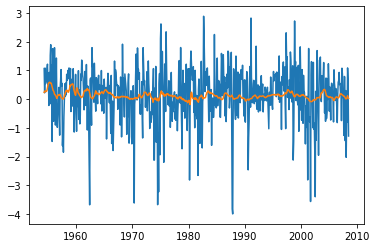

In [530]:
plt.plot(prev_data[['train','prev']])

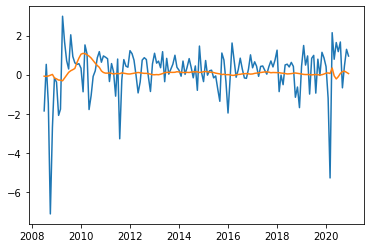

In [531]:
plt.plot(pred_data[['test','pred']])

In [532]:
## Output confusion matrix ##
a, b, c, d = 0, 0, 0, 0
for idx in range(prev_data.shape[0]):
    if prev_data[['train']].iloc[idx][0] >= 0 and prev_data[['prev']].iloc[idx][0] >= 0:
        a += 1
    elif prev_data[['train']].iloc[idx][0] >= 0 and prev_data[['prev']].iloc[idx][0] < 0:
        b += 1
    elif prev_data[['train']].iloc[idx][0] < 0 and prev_data[['prev']].iloc[idx][0] >= 0:
        c += 1
    elif prev_data[['train']].iloc[idx][0] < 0 and prev_data[['prev']].iloc[idx][0] < 0:
        d += 1
print('train confusion = ', a, b, c, d)


a, b, c, d = 0, 0, 0, 0
for idx in range(pred_data.shape[0]):
    if pred_data[['test']].iloc[idx][0] >= 0 and pred_data[['pred']].iloc[idx][0] >= 0:
        a += 1
    elif pred_data[['test']].iloc[idx][0] >= 0 and pred_data[['pred']].iloc[idx][0] < 0:
        b += 1
    elif pred_data[['test']].iloc[idx][0] < 0 and pred_data[['pred']].iloc[idx][0] >= 0:
        c += 1
    elif pred_data[['test']].iloc[idx][0] < 0 and pred_data[['pred']].iloc[idx][0] < 0:
        d += 1
print('test confusion = ', a, b, c, d)

train confusion =  358 36 222 34
test confusion =  84 16 37 13


In [533]:
pred, prev = [1 if a > 0. else 0 for a in pred_prob], [1 if a > 0. else 0 for a in prev_prob]

prev_data = filled_data[1:][window:-150]
prev_data.insert(2, 'prediction', prev, True)

asset = 1
asset_list_1 = [asset]
for i in range(len(prev) - 1):
    asset = asset * prev_data[['S&P500']].iloc[i + 1][0] / prev_data[['S&P500']].iloc[i][0]
    asset_list_1.append(asset)

asset = 1
asset_list_2 = [asset]
for i in range(len(prev) - 1):
    if prev_data[['prediction']].iloc[i + 1][0] == 1:
        asset = asset * prev_data[['S&P500']].iloc[i + 1][0] / prev_data[['S&P500']].iloc[i][0]
    else:
        asset = asset * (2 - prev_data[['S&P500']].iloc[i + 1][0] / prev_data[['S&P500']].iloc[i][0])
    asset_list_2.append(asset)

prev_data.insert(2, 'bench', asset_list_1, True)
prev_data.insert(2, 'etf', asset_list_2, True)



pred_data = filled_data[1:][-150:]
pred_data.insert(2, 'prediction', pred, True)

asset = 1
asset_list_1 = [asset]
for i in range(len(pred) - 1):
    asset = asset * pred_data[['S&P500']].iloc[i + 1][0] / pred_data[['S&P500']].iloc[i][0]
    asset_list_1.append(asset)

asset = 1
asset_list_2 = [asset]
for i in range(len(pred) - 1):
    if pred_data[['prediction']].iloc[i + 1][0] == 1:
        asset = asset * pred_data[['S&P500']].iloc[i + 1][0] / pred_data[['S&P500']].iloc[i][0]
    else:
        asset = asset * (2 - pred_data[['S&P500']].iloc[i + 1][0] / pred_data[['S&P500']].iloc[i][0])
    asset_list_2.append(asset)

pred_data.insert(2, 'bench', asset_list_1, True)
pred_data.insert(2, 'etf', asset_list_2, True)


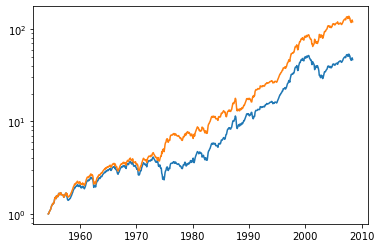

In [534]:
plt.plot(prev_data[['bench','etf']])
plt.yscale('log')

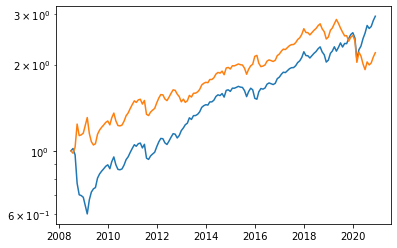

In [535]:
plt.plot(pred_data[['bench','etf']])
plt.yscale('log')